In [2]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patheffects as fx

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# 1. <a id='toc1_'></a>Load data  [&#128285;](#toc0_)

In [3]:
# Load catalogs
# Tremor
trm = pd.read_csv('../data/nankai/processed/nank_trm_0404_0413.csv', parse_dates=['date'])

# Earthquakes
eq = pd.read_csv('../data/nankai/processed/nank_eq_0404_0413.csv', parse_dates=['date'])

In [4]:
# Load results and extract results of interest
min_mag = 2.2
dist = 50
v_min = 3.5
dx_bin = 10
cc_thr = 0.07

# Load results
results = pickle.load(open('../results/nankai/nank_synch.pkl', 'rb'))

n_felt_eqs = results['n_felt_eqs']
corr_lengths = results['corr_lengths']

# Extract
n_felt_eq = n_felt_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km']
corr_length = corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}']
n_tremor = results['n_tremors'][f'dx{dx_bin:d}km']
n_min_trm = results['parameters']['min_n_tremor_dx10km']

xmin = results['parameters']['xmin_bin']
xmax = results['parameters']['xmax_bin']
x_bin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)

no_trm = n_tremor < n_min_trm
corr_length[no_trm] = np.nan
n_felt_eq[no_trm] = np.nan

# 2. <a id='toc2_'></a>Figures [&#128285;](#toc0_)

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_24882/3204097880.py:102: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], s=5, c=to_rgba('C1', .5), label='Tremor')
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_24882/3204097880.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], s=5, c=to_rgba('k', .5), label='Earthquakes')


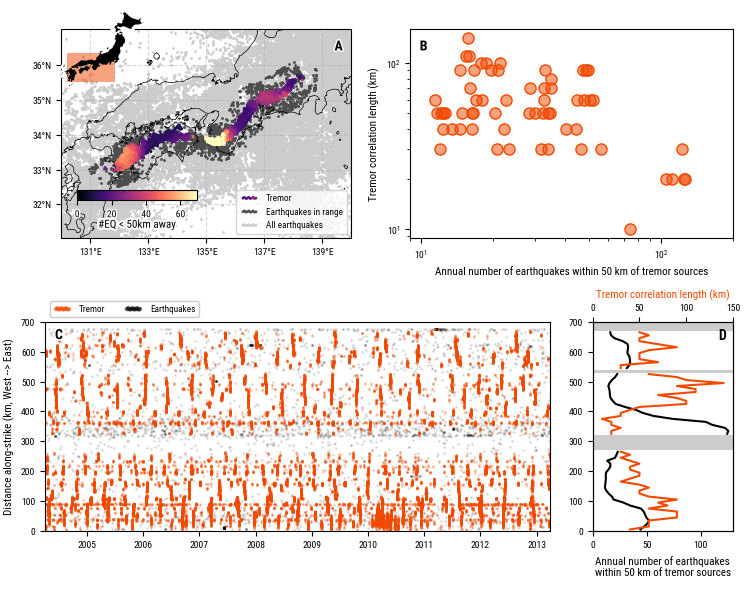

In [5]:
# Plot
with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 15])/2.54)
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1])

    plt.subplots_adjust(left=0.06, right=0.98, top=.95, bottom=0.1, wspace=0.3, hspace=0.4)

    # Map
    crs = ccrs.Mercator(central_longitude=trm.lon.mean())
    lon_min = eq.lon.min()
    lon_max = eq.lon.max()
    lat_min = eq.lat.min()
    lat_max = eq.lat.max()

    ax = fig.add_subplot(gs[0, :2], projection=crs)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines(lw=.5)

    sc = ax.scatter(trm.lon, trm.lat, c=trm[f'm{min_mag:.1f}in{dist:d}km'], s=1, cmap='magma', transform=ccrs.PlateCarree(), vmin=0, vmax=np.percentile(trm[f'm{min_mag:.1f}in{dist:d}km'], 95), zorder=2, label='Tremor', rasterized=True)
    ax.scatter(eq.lon[(eq.mag > min_mag) & (eq.dist2trm < dist)], eq.lat[(eq.mag > min_mag) & (eq.dist2trm < dist)], c='.3', s=1, transform=ccrs.PlateCarree(), zorder=1, label='Earthquakes in range', rasterized=True)
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=ccrs.PlateCarree(), zorder=0, label='All earthquakes', rasterized=True)

    ax.legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize='small', framealpha=.8, scatterpoints=10, markerscale=1)

    # Colorbar
    x_min_ax = 0.1; y_min_ax = 0.18
    w_ax = 0.37; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    h_fig = y_max_fig - y_min_fig
    w_fig = x_max_fig - x_min_fig

    cb_ax= fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    cbar = plt.colorbar(sc, cax=cb_ax, orientation='horizontal', label="#EQ < {:d}km away".format(dist))

    for label in cb_ax.get_xticklabels():
        label.set(path_effects=[fx.withStroke(linewidth=2, foreground='w')])
    cb_ax.xaxis.get_label().set(path_effects=[fx.withStroke(linewidth=3, foreground='w')])
    cb_ax.xaxis.get_label().set_va('center')

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    ax.text(0.97, 0.95, 'A', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='right', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])


    # Inset
    # get Japan country shape
    import shapely.geometry as sgeom
    import cartopy.io.shapereader as shpreader

    shpfilename = shpreader.natural_earth(resolution='50m',
                                        category='cultural',
                                        name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    japan = None
    for country in countries:
        if country.attributes['NAME'] == 'Japan':
            japan = country.geometry

    ax = plt.axes([.07, .85, .13, .13], projection=ccrs.PlateCarree())
    ax.axis('off')
    ax.set_extent([128, 146, 29.8, 45.7], crs=ccrs.PlateCarree())
    ax.add_geometries([japan], ccrs.PlateCarree(), facecolor='k', edgecolor='w', lw=4, zorder=0)    
    ax.add_geometries([japan], ccrs.PlateCarree(), facecolor='k', edgecolor='none', lw=1, zorder=2)

    # show patch of main map
    rect = plt.Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min, transform=ccrs.PlateCarree(), edgecolor='none', facecolor=to_rgba('C1', .5), zorder=1)
    ax.add_patch(rect)

    # Dot cloud
    ax = fig.add_subplot(gs[0, 2:])
    ax.set_xlabel('Annual number of earthquakes within 50 km of tremor sources')
    ax.set_ylabel('Tremor correlation length (km)')

    ax.plot(n_felt_eq, corr_length, 'o', ms=8, mec='C1', mfc=to_rgba('C1', .5))

    ax.set_xlim(9, 200)
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.text(0.03, 0.95, 'B', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Time-strike activity
    ax = fig.add_subplot(gs[1, :3])
    ax.set_ylabel('Distance along-strike (km, West --> East)')

    ax.plot(trm.date, trm.xf, 'o', ms=1, color=to_rgba('C1', .2), rasterized=True)
    ax.plot(eq.date[(eq.mag > min_mag) & (eq.dist2trm < dist)], eq.xf[(eq.mag > min_mag) & (eq.dist2trm < dist)], 'o', ms=1., color=to_rgba('k', .1), zorder=0, rasterized=True)

    ax.set_xlim(trm.date.min(), trm.date.max())
    ax.set_ylim(0, 700)

    ax.scatter([], [], s=5, c=to_rgba('C1', .5), label='Tremor')
    ax.scatter([], [], s=5, c=to_rgba('k', .5), label='Earthquakes')
    ax.legend(loc='lower left', bbox_to_anchor=(0, 1.), framealpha=1, fontsize='small', scatterpoints=10, markerscale=1, ncols=2)

    ax.text(0.02, 0.97, 'C', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Histogram
    ax = fig.add_subplot(gs[1, 3], sharey=ax)
    ax.set_xlabel('Annual number of earthquakes\nwithin 50 km of tremor sources')
    ax.set_xlim(0, 130)

    ax.plot(n_felt_eq, x_bin_edges[:-1]+dx_bin/2, c='k')

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 150)
    ax_cc.plot(corr_length, x_bin_edges[:-1]+dx_bin/2, 'C1')
    ax_cc.set_xlabel('Tremor correlation length (km)', color='C1')

    for ii in np.where(no_trm)[0]:
        ax.axhspan(x_bin_edges[ii], x_bin_edges[ii+1], fc='.8', ec='none', zorder=0)

    ax.text(0.95, 0.97, 'D', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='right', va='top')
    
    plt.savefig('../figures/nankai_supp.png', dpi=300)
    plt.savefig('../figures/nankai_supp.pdf', dpi=300)
    plt.show()